In [1]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [6.5, 5]

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.labelsize'] = 30
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["lines.linewidth"] = 3

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['xtick.minor.visible'] =  True
plt.rcParams['ytick.minor.visible'] =  True


plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.bbox'] = 'tight'

matplotlib.rc('font', weight='bold')

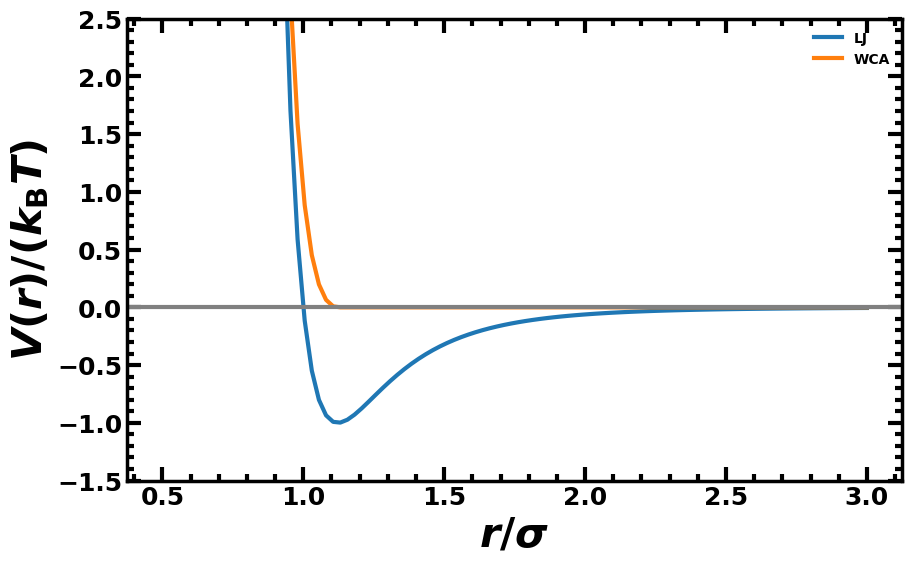

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

def lj_pot(x, epsilon, sigma, r_cut, c_shift=0.0):
    pot = 4.0 * epsilon * ((sigma / x)**12 - (sigma / x)**6) + c_shift
    pot[x > r_cut] = 0.
    return pot

epsilon = 1.0  # energy in units of k_BT
sigma = 1.0    # distance in units of sigma

xs = np.linspace(0.5, 3, 100)
ys_lj = lj_pot(xs, epsilon, sigma, r_cut=xs[-1])
ys_WCA = lj_pot(xs, epsilon, sigma, r_cut=2**(1/6) * sigma, c_shift=epsilon)

fig = plt.figure(figsize=(10, 6))
plt.plot(xs, ys_lj, label='LJ')
plt.plot(xs, ys_WCA, label='WCA')
plt.axhline(y=0, color='grey')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"$V(r)/(k_{\mathrm{B}}T)$")
plt.legend()
plt.ylim(-1.5, 2.5)
plt.show()

Density =  0.512
Running MC for 100000 steps ...
MC step: 1000
MC step: 1100
MC step: 1200
MC step: 1300
MC step: 1400
MC step: 1500
MC step: 1600
MC step: 1700
MC step: 1800
MC step: 1900
MC step: 2000
MC step: 2100
MC step: 2200
MC step: 2300
MC step: 2400
MC step: 2500
MC step: 2600
MC step: 2700
MC step: 2800
MC step: 2900
MC step: 3000
MC step: 3100
MC step: 3200
MC step: 3300
MC step: 3400
MC step: 3500
MC step: 3600
MC step: 3700
MC step: 3800
MC step: 3900
MC step: 4000
MC step: 4100
MC step: 4200
MC step: 4300
MC step: 4400
MC step: 4500
MC step: 4600
MC step: 4700
MC step: 4800
MC step: 4900
MC step: 5000
MC step: 5100
MC step: 5200
MC step: 5300
MC step: 5400
MC step: 5500
MC step: 5600
MC step: 5700
MC step: 5800
MC step: 5900
MC step: 6000
MC step: 6100
MC step: 6200
MC step: 6300
MC step: 6400
MC step: 6500
MC step: 6600
MC step: 6700
MC step: 6800
MC step: 6900
MC step: 7000
MC step: 7100
MC step: 7200
MC step: 7300
MC step: 7400
MC step: 7500
MC step: 7600
MC step: 7700

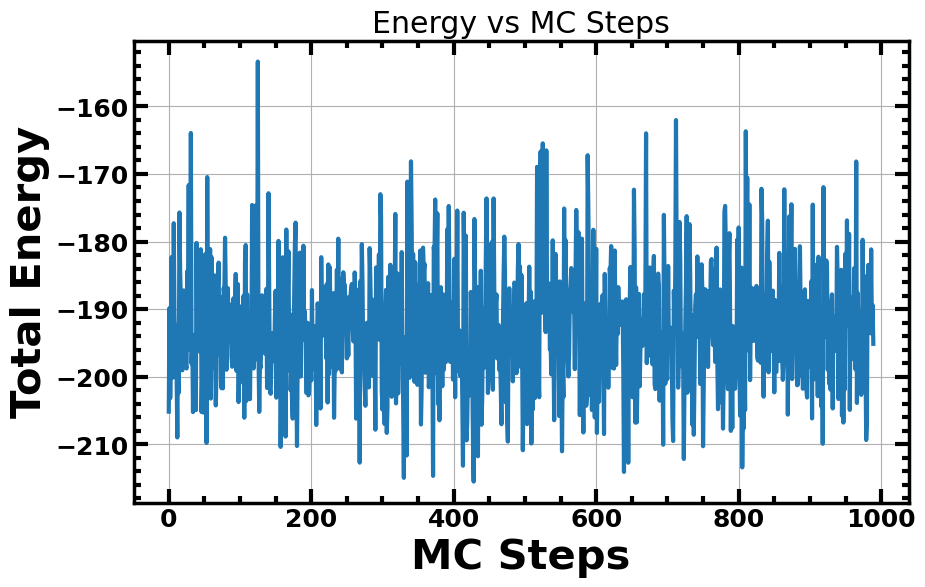

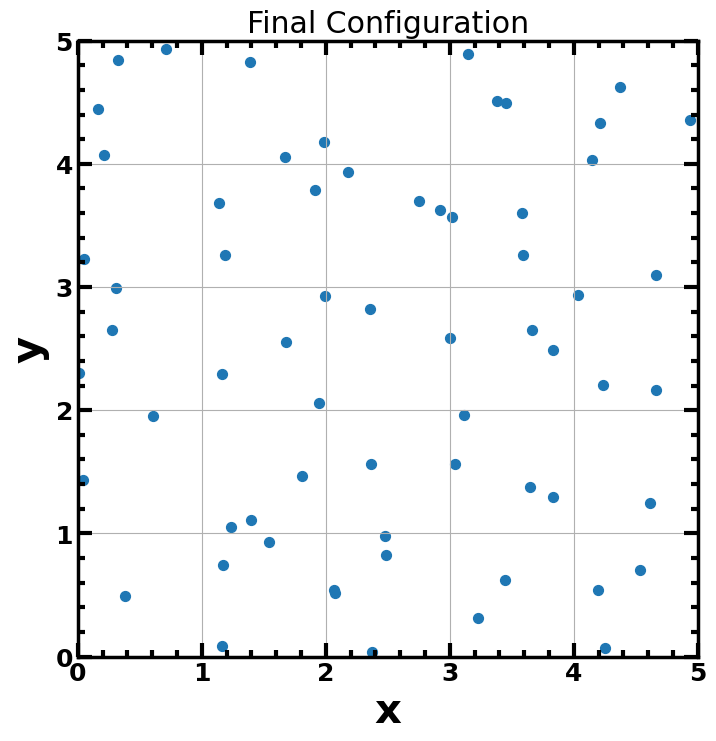

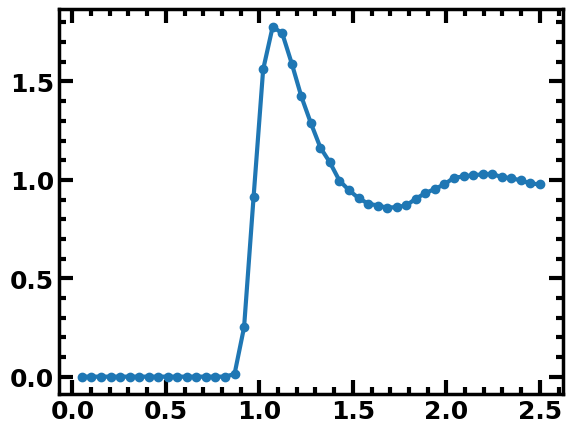

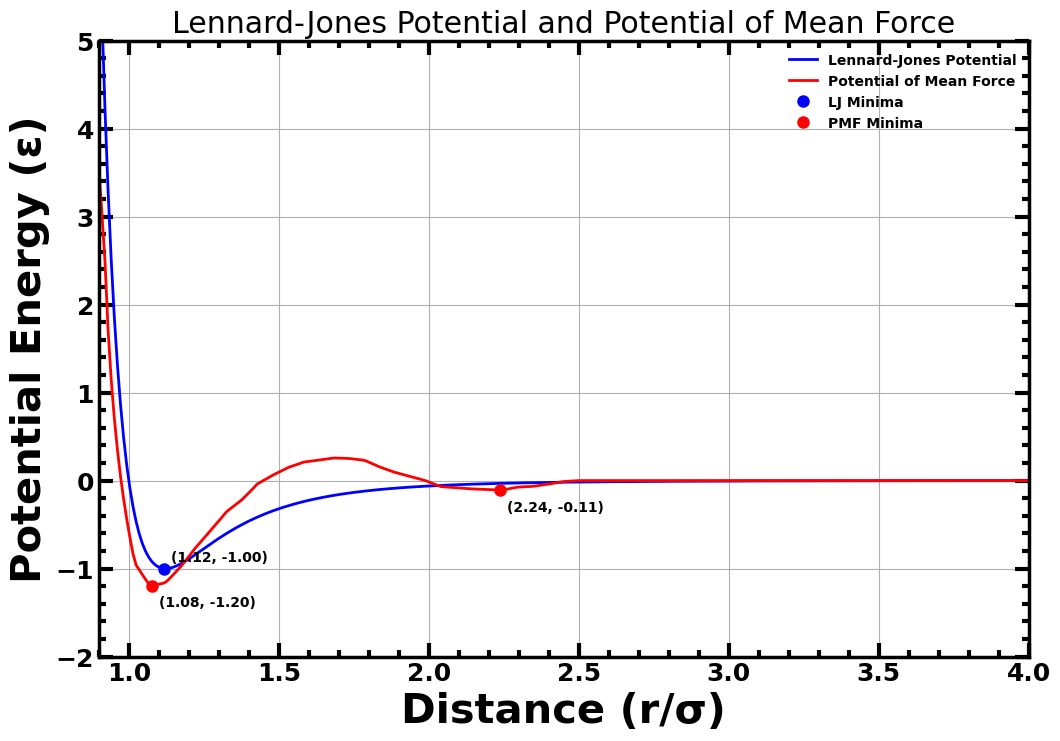

Lennard-Jones Potential Minima:
Minimum 1: r = 1.118σ, Depth = -0.999ε

Potential of Mean Force Minima:
Minimum 1: r = 1.076σ, Depth = -1.195ε
Minimum 2: r = 2.237σ, Depth = -0.107ε


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

@jit(nopython=True)
def potnrg_part(pos,i,boxl):
    '''
    Parameters
    ----------
    pos : array_like
        Coordinates of particles : N x ndim
    i : integer
        Particle number for which energy needs to be computed
    Returns
    -------
    nrg : float
    Energy of i-th particle
    '''
    sigma = 1.0
    eps   = 1.0
    r_cut = 4.0
    E_cut = 4*eps*((sigma/r_cut)**12 - (sigma/r_cut)**6)
    nrg = 0.0
    for j in range(len(pos)):
        if i != j:
            dpos = pos[i]-pos[j]
            # Perform transformation for minimum image convention (MIC)
            for comp in range(len(dpos)):
                if np.abs(dpos[comp]) > boxl/2.0:
                    dpos[comp] -= np.sign(dpos[comp])*boxl
            r = np.linalg.norm(dpos)
           
            if r <= r_cut:
                nrg += 4*eps*((sigma/r)**12 - (sigma/r)**6) - E_cut
    return nrg


@jit(nopython=True)
def potnrg_total(pos,boxl):
    '''
    Parameters
    ----------
    pos : array_like
        Coordinates of particles : N x ndim

    Returns
    -------
    A tuple of total energy (totnrg) and energy of all particles (allnrg)
    '''
    allnrg = np.zeros(len(pos))
    sigma = 1.0
    eps   = 1.0
    r_cut = 4.0
    E_cut = 4*eps*((sigma/r_cut)**12 - (sigma/r_cut)**6)
    totnrg = 0.0
    for i in range(len(pos)-1):
        for j in range(i+1, len(pos)):
            dpos = pos[i]-pos[j]
            # Perform transformation for minimum image convention (MIC)
            for comp in range(len(dpos)):
                if np.abs(dpos[comp]) > boxl/2.0:
                    dpos[comp] -= np.sign(dpos[comp])*boxl
            r = np.linalg.norm(dpos)

            if r <= r_cut:
                nrg = 4*eps*((sigma/r)**12 - (sigma/r)**6) - E_cut
                totnrg += nrg
                allnrg[i] += nrg
                allnrg[j] += nrg
    return totnrg, allnrg


@jit(nopython=True)
def MC_NVT(pos, boxl, kT=1.0, steps=1, equib=0, sampl_freq=1):
    print("Running MC for", steps, "steps ...")
    npart = len(pos)
    ndim = len(pos[0])
    maxl = 1.0 # Adjustable parameter ...
    potnrg = potnrg_total(pos,boxl)[0]
    accept = 0
    
    nsample = int((steps - equib)/sampl_freq)
    
    traj_nrg = np.zeros(nsample)
    traj_pos = np.zeros((nsample,npart,ndim))
    
    isampl = 0
    for step in range(steps):
        for _ in range(npart):
            part = np.random.randint(npart)
            oldnrg = potnrg_part(pos,part,boxl)
            dpos = np.random.uniform(-maxl,maxl,ndim)
            pos[part] += dpos
            pos = np.mod(pos,boxl) # Wrap particles due to PBC            
            newnrg = potnrg_part(pos,part,boxl)
            delnrg = newnrg - oldnrg
            if (np.random.uniform(0,1) < np.exp(-delnrg/kT)):
                potnrg += delnrg
                accept += 1
            else:
                pos[part] -= dpos
                pos = np.mod(pos,boxl)

        if ((step >= equib) and (step % sampl_freq == 0)):
            print("MC step:", step)
            traj_nrg[isampl] = potnrg
            traj_pos[isampl] = pos
            isampl += 1
    
    print("Acceptance = ", 100*(accept/(steps*npart)))
    return traj_pos, traj_nrg


@jit(nopython=True)
def RDF(pos,boxl,bw=0.01):
    steps = pos.shape[0]
    npart = pos.shape[1]
    ndim = pos.shape[2]

    rho = npart/(boxl**ndim)
    
    nbins = int(boxl/(2*bw))
    rdf = np.zeros(nbins)
    rbins = np.linspace(0,boxl/2,nbins) # Create grid/bins for r
    
    for step in range(steps):
        for i in range(npart):
            for j in range(npart):
                if i != j:
                    dpos = (pos[step][i]-pos[step][j])
                    # Perform transformation for minimum image convention (MIC)
                    for comp in range(len(dpos)):
                        if np.abs(dpos[comp]) > boxl/2.0:
                            dpos[comp] -= np.sign(dpos[comp])*boxl
                    r = np.linalg.norm(dpos)
                    if r <= boxl/2:
                        ibin = int(r / bw)
                        rdf[ibin] += 1
    if ndim == 3:
        rdf[1:] /= (4 * np.pi * rbins[1:]**2 * bw * rho * steps * npart) # for 3D RDF
    elif ndim == 2:
        rdf[1:] /= (2 * np.pi * rbins[1:] * bw * rho * steps * npart) # for 2D RDF
    else:
        print("Dimensionality not supported!")
        return None
    return rbins[1:], rdf[1:]

# Lennard-Jones potential
def lj_potential(r, sigma=1.0, epsilon=1.0):
    """Calculate Lennard-Jones potential"""
    return 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)

# Potential of mean force from RDF
def pmf_from_rdf(r, g_r, kT=1.0):
    """Calculate potential of mean force from radial distribution function"""
    # Avoid log(0) issues by setting g_r to a small positive value where it's zero
    g_r_safe = np.where(g_r > 1e-10, g_r, 1e-10)
    return -kT * np.log(g_r_safe)

# Find minima in a 1D array
def find_minima(x, y):
    """Find minima in a 1D function"""
    peaks, _ = find_peaks(-y)
    
    minima = []
    min_values = []
    for peak in peaks:
        if peak > 0 and peak < len(y)-1:
            if y[peak-1] > y[peak] and y[peak+1] > y[peak]:
                minima.append(x[peak])
                min_values.append(y[peak])
    
    return minima, min_values

#Initialise ...
boxl = 5 # Unit of sigma
ndim = 3
npart = 64 # Number of particles
rho = npart/(boxl**ndim)
print("Density = ", rho)
# Initialise with random coordinates
pos = np.random.random((npart,ndim))*boxl 
traj_pos, traj_nrg = MC_NVT(pos, boxl, kT=2.0, steps=100000, equib=1000, sampl_freq=100)

# Plot energy versus MC steps ...
plt.figure(figsize=(10, 6))
plt.plot(traj_nrg)
plt.xlabel('MC Steps')
plt.ylabel('Total Energy')
plt.title('Energy vs MC Steps')
plt.grid(True)
plt.show()

# Visualise final frame ...
plt.figure(figsize=(8, 8))
plt.scatter(traj_pos[-1][:,0], traj_pos[-1][:,1], s=50)
plt.xlim(0, boxl)
plt.ylim(0, boxl)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Final Configuration')
plt.grid(True)
plt.show()

# Calculate RDF
rbins, rdf = RDF(traj_pos, boxl, bw=0.05)

# Calculate LJ potential
r_values = np.linspace(0.9, 4.0, 300)  # Avoid r=0 division
lj_pot = lj_potential(r_values)

# Calculate PMF from RDF
rdf_interp = interp1d(rbins, rdf, bounds_error=False, fill_value=(rdf[0], rdf[-1]))
rdf_at_r_values = rdf_interp(r_values)
pmf = pmf_from_rdf(r_values, rdf_at_r_values, kT=2.0)

# Shift PMF to zero at large r for better comparison
pmf_shift = pmf - pmf[-1]

# Find minima for LJ potential
lj_minima, lj_min_values = find_minima(r_values, lj_pot)

# Find minima for PMF
pmf_minima, pmf_min_values = find_minima(r_values, pmf_shift)

rbins, rdf = RDF(traj_pos,boxl,bw=0.05)
plt.plot(rbins, rdf,'-o')
plt.show()

# Plot both potentials
plt.figure(figsize=(12, 8))
plt.plot(r_values, lj_pot, 'b-', linewidth=2, label='Lennard-Jones Potential')
plt.plot(r_values, pmf_shift, 'r-', linewidth=2, label='Potential of Mean Force')

# Mark minima
if lj_minima:
    plt.plot(lj_minima, lj_min_values, 'bo', markersize=8, label='LJ Minima')
    for i, (r, u) in enumerate(zip(lj_minima, lj_min_values)):
        plt.annotate(f'({r:.2f}, {u:.2f})', (r, u), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10)

if pmf_minima:
    plt.plot(pmf_minima, pmf_min_values, 'ro', markersize=8, label='PMF Minima')
    for i, (r, u) in enumerate(zip(pmf_minima, pmf_min_values)):
        plt.annotate(f'({r:.2f}, {u:.2f})', (r, u), xytext=(5, -15), 
                    textcoords='offset points', fontsize=10)

plt.xlabel('Distance (r/σ)')
plt.ylabel('Potential Energy (ε)')
plt.title('Lennard-Jones Potential and Potential of Mean Force')
plt.legend()
plt.grid(True)
plt.ylim(-2, 5)  # Adjust ylim to see minima clearly
plt.xlim(0.9, 4.0)
plt.show()

# Print results
print("Lennard-Jones Potential Minima:")
for i, (r, u) in enumerate(zip(lj_minima, lj_min_values)):
    print(f"Minimum {i+1}: r = {r:.3f}σ, Depth = {u:.3f}ε")

print("\nPotential of Mean Force Minima:")
for i, (r, u) in enumerate(zip(pmf_minima, pmf_min_values)):
    print(f"Minimum {i+1}: r = {r:.3f}σ, Depth = {u:.3f}ε")

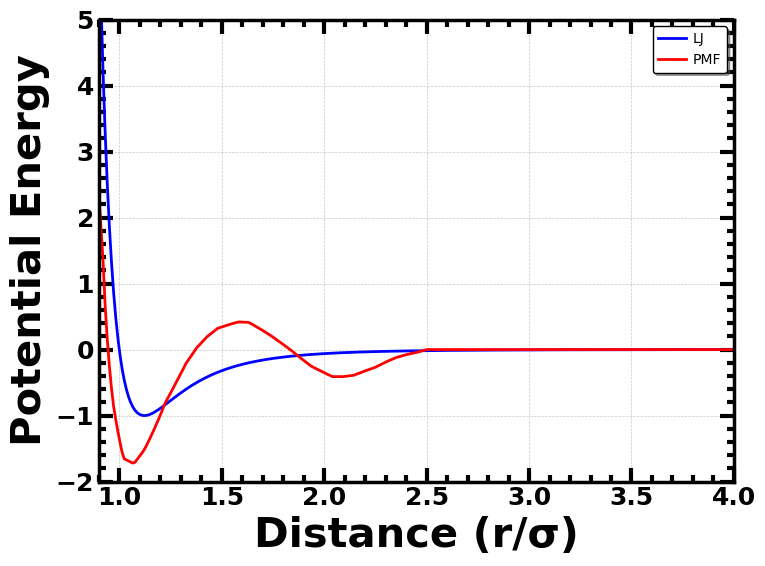

In [13]:
# Plot both potentials
plt.figure(figsize=(8, 6))
plt.plot(r_values, lj_pot, 'b-', linewidth=2, label='LJ')
plt.plot(r_values, pmf_shift, 'r-', linewidth=2, label='PMF')

# # Mark minima
# if lj_minima:
#     plt.plot(lj_minima, lj_min_values, 'bo', markersize=8, label='LJ Minima')
#     for i, (r, u) in enumerate(zip(lj_minima, lj_min_values)):
#         plt.annotate(f'({r:.2f}, {u:.2f})', (r, u), xytext=(5, 5), 
#                     textcoords='offset points', fontsize=10)

# if pmf_minima:
#     plt.plot(pmf_minima, pmf_min_values, 'ro', markersize=8, label='PMF Minima')
#     for i, (r, u) in enumerate(zip(pmf_minima, pmf_min_values)):
#         plt.annotate(f'({r:.2f}, {u:.2f})', (r, u), xytext=(5, -15), 
#                     textcoords='offset points', fontsize=10)

plt.xlabel('Distance (r/σ)')
plt.ylabel('Potential Energy')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(ncol=1, loc='upper right', 
          frameon=True, fancybox=True,
          shadow=True, edgecolor='black',
          handlelength=2.0, handletextpad=0.5,
          columnspacing=1.0, prop={'weight': 'normal'})
plt.ylim(-2, 5)
plt.xlim(0.9, 4.0)
plt.tight_layout()
plt.savefig('lj_vs_pmf4.png', dpi=500, bbox_inches="tight")
plt.show()

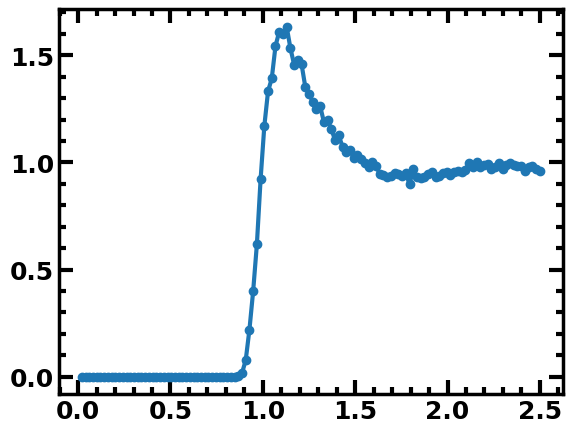

In [5]:
rbins, rdf = RDF(traj_pos,boxl,bw=0.02)
plt.plot(rbins, rdf,'-o')
plt.show()

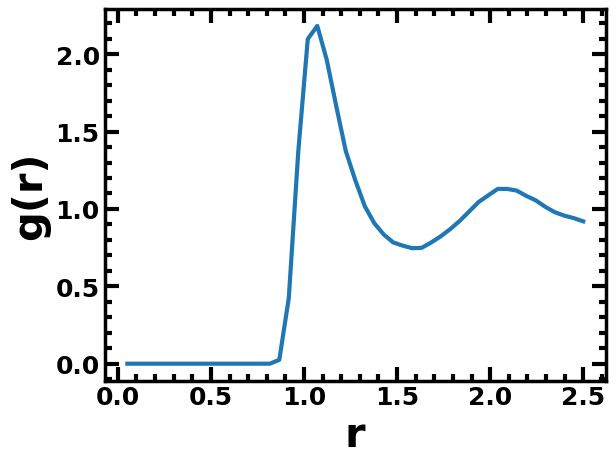

In [14]:
# Calculate RDF
rbins, rdf = RDF(traj_pos, boxl, bw=0.1)

# Calculate LJ potential
r_values = np.linspace(0.9, 4.0, 300)  # Avoid r=0 division
lj_pot = lj_potential(r_values)

# Calculate PMF from RDF
rdf_interp = interp1d(rbins, rdf, bounds_error=False, fill_value=(rdf[0], rdf[-1]))
rdf_at_r_values = rdf_interp(r_values)
pmf = pmf_from_rdf(r_values, rdf_at_r_values, kT=2.0)
pmf_shift = pmf - pmf[-1]

lj_minima, lj_min_values = find_minima(r_values, lj_pot)
pmf_minima, pmf_min_values = find_minima(r_values, pmf_shift)

rbins, rdf = RDF(traj_pos,boxl,bw=0.05)
plt.plot(rbins, rdf)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.tight_layout()
plt.savefig('rdf4.png', dpi=500, bbox_inches="tight")
plt.show()

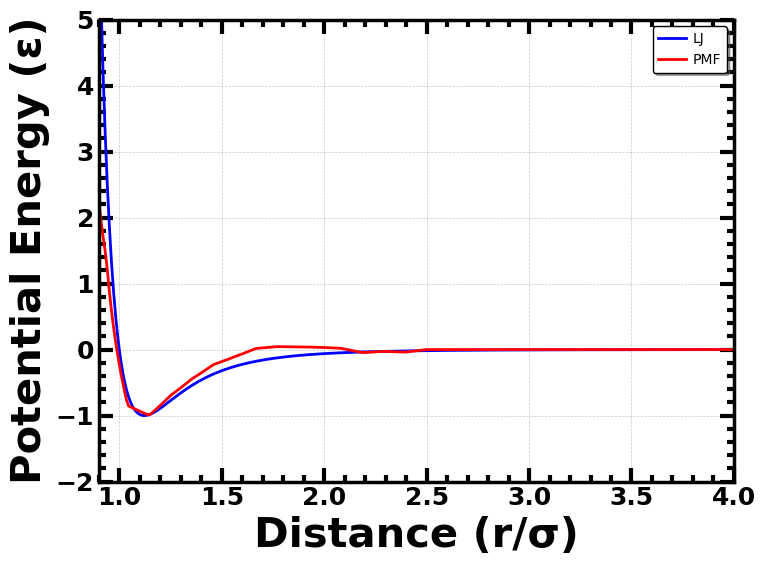

In [7]:
# Plot both potentials
plt.figure(figsize=(8, 6))
plt.plot(r_values, lj_pot, 'b-', linewidth=2, label='LJ')
plt.plot(r_values, pmf_shift, 'r-', linewidth=2, label='PMF')

# # Mark minima
# if lj_minima:
#     plt.plot(lj_minima, lj_min_values, 'bo', markersize=8, label='LJ Minima')
#     for i, (r, u) in enumerate(zip(lj_minima, lj_min_values)):
#         plt.annotate(f'({r:.2f}, {u:.2f})', (r, u), xytext=(5, 5), 
#                     textcoords='offset points', fontsize=10)

# if pmf_minima:
#     plt.plot(pmf_minima, pmf_min_values, 'ro', markersize=8, label='PMF Minima')
#     for i, (r, u) in enumerate(zip(pmf_minima, pmf_min_values)):
#         plt.annotate(f'({r:.2f}, {u:.2f})', (r, u), xytext=(5, -15), 
#                     textcoords='offset points', fontsize=10)

plt.xlabel('Distance (r/σ)')
plt.ylabel('Potential Energy (ε)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(ncol=1, loc='upper right', 
          frameon=True, fancybox=True,
          shadow=True, edgecolor='black',
          handlelength=2.0, handletextpad=0.5,
          columnspacing=1.0, prop={'weight': 'normal'})
plt.ylim(-2, 5)
plt.xlim(0.9, 4.0)
plt.tight_layout()
# plt.savefig('lj_vs_pmf1.png', dpi=500, bbox_inches="tight")
plt.show()

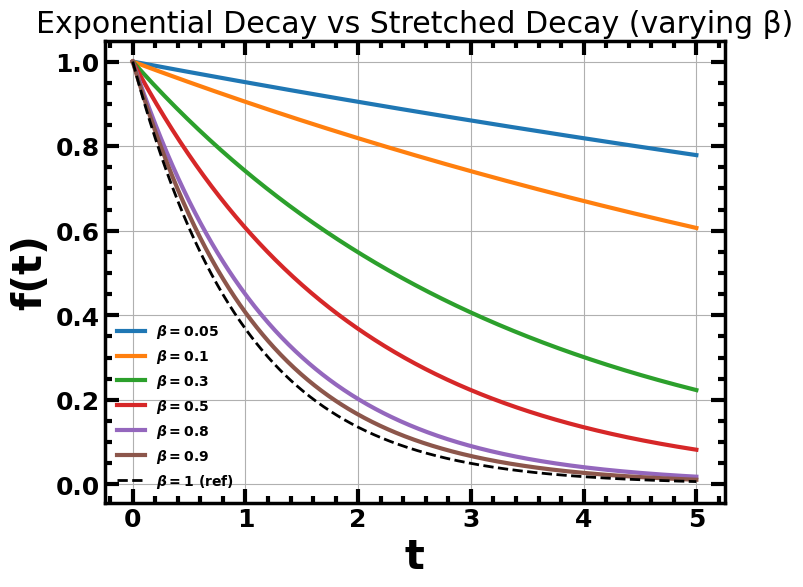

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau = 1.0
t = np.linspace(0, 5, 500)
ref = np.exp(-t/tau)

# Beta values to plot
betas = [0.05, 0.1, 0.3, 0.5, 0.8, 0.9]

plt.figure(figsize=(8,6))

# Plot stretched exponentials
for beta in betas:
    g = np.exp(-t/tau)**beta
    plt.plot(t, g, label=fr"$\beta={beta}$")

# Plot reference exponential
plt.plot(t, ref, 'k--', linewidth=2, label=r"$\beta=1$ (ref)")

plt.title("Exponential Decay vs Stretched Decay (varying β)")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()


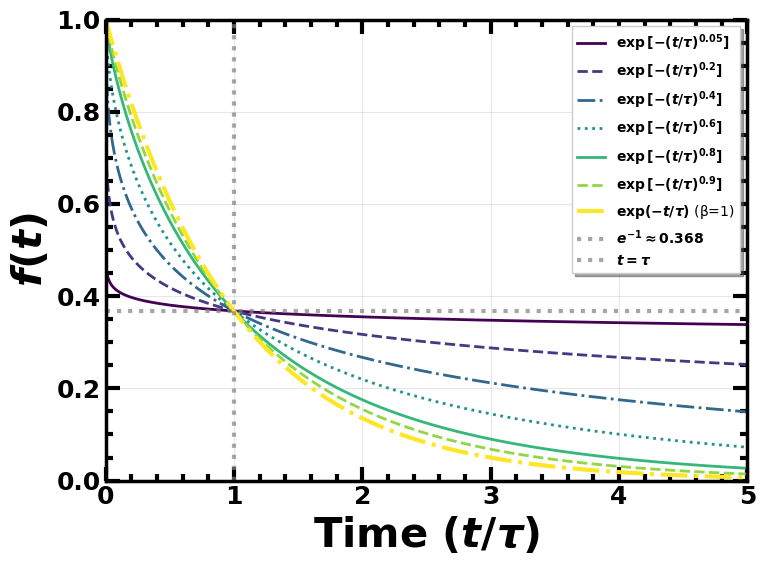

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau = 1.0
t = np.linspace(0, 5, 1000)  # time values from 0 to 5τ

# Beta values to test
beta_values = [0.05, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Colormap for auto-colors
colors = plt.cm.viridis(np.linspace(0, 1, len(beta_values)))
line_styles = ['-', '--', '-.', ':']  

# Plot
for i, beta in enumerate(beta_values):
    if np.isclose(beta, 1.0):
        y = np.exp(-t / tau)
        label = r"$\exp(-t/\tau)$ (β=1)"
        lw = 3
    else:
        y = np.exp(-(t / tau) ** beta)
        label = rf"$\exp\left[-(t/\tau)^{{{beta}}}\right]$"
        lw = 2

    ax.plot(
        t, y,
        color=colors[i],
        linestyle=line_styles[i % len(line_styles)],
        linewidth=lw,
        label=label
    )

# Reference lines
ax.axhline(y=np.exp(-1), color='gray', linestyle=':', alpha=0.7, label=r"$e^{-1} \approx 0.368$")
ax.axvline(x=1, color='gray', linestyle=':', alpha=0.7, label=r"$t = \tau$")



# Formatting
ax.set_xlabel(r"Time ($t/\tau$)")
ax.set_ylabel(r"$f(t)$")
ax.set_xlim(0, 5)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

ax.legend(frameon=True, fancybox=False, shadow=True, loc='upper right', prop={'weight': 'normal'})

fig.tight_layout()

plt.savefig('exp_fit.png', dpi=500, bbox_inches="tight")
plt.show()


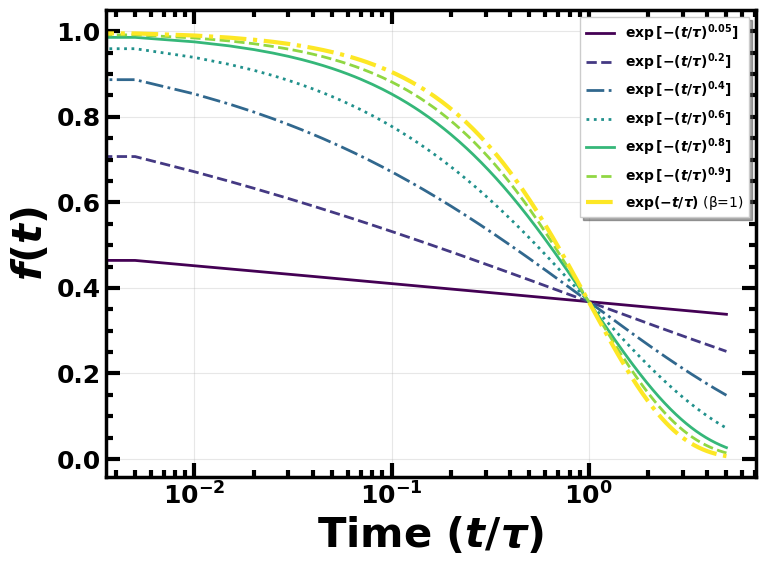

In [10]:

import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau = 1.0
t = np.linspace(0, 5, 1000)  # time values from 0 to 5τ

# Beta values 
beta_values = [0.05, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]


fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(beta_values)))
line_styles = ['-', '--', '-.', ':']  

# Plot
for i, beta in enumerate(beta_values):
    if np.isclose(beta, 1.0):
        y = np.exp(-t / tau)
        label = r"$\exp(-t/\tau)$ (β=1)"
        lw = 3
    else:
        y = np.exp(-(t / tau) ** beta)
        label = rf"$\exp\left[-(t/\tau)^{{{beta}}}\right]$"
        lw = 2

    ax.plot(
        t, y,
        color=colors[i],
        linestyle=line_styles[i % len(line_styles)],
        linewidth=lw,
        label=label
    )

# Formatting
ax.set_xlabel(r"Time ($t/\tau$)")
ax.set_ylabel(r"$f(t)$")
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 1)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

ax.legend(frameon=True, fancybox=False, shadow=True, loc='upper right', prop={'weight': 'normal'})

fig.tight_layout()

plt.savefig('exp_fit.png', dpi=500, bbox_inches="tight")
plt.show()


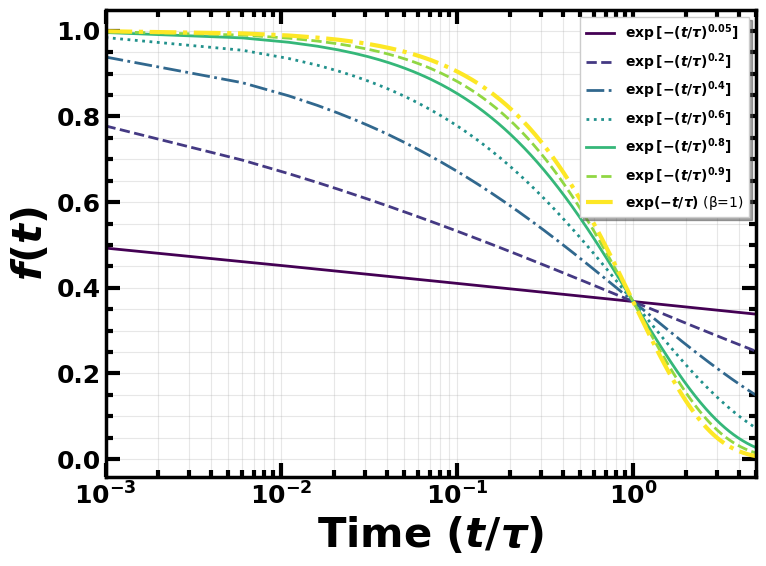

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
tau = 1.0
t = np.linspace(0.001, 5, 1000)  # start slightly above 0 to avoid log(0) issues

# Beta values
beta_values = [0.05, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(beta_values)))
line_styles = ['-', '--', '-.', ':']

# Plot each curve
for i, beta in enumerate(beta_values):
    if np.isclose(beta, 1.0):
        y = np.exp(-t / tau)
        label = r"$\exp(-t/\tau)$ (β=1)"
        lw = 3  # thicker line for β=1
    else:
        y = np.exp(-(t / tau) ** beta)
        label = rf"$\exp\left[-(t/\tau)^{{{beta}}}\right]$"
        lw = 2

    ax.plot(
        t, y,
        color=colors[i],
        linestyle=line_styles[i % len(line_styles)],
        linewidth=lw,
        label=label
    )

# Formatting
ax.set_xlabel(r"Time ($t/\tau$)")
ax.set_ylabel(r"$f(t)$")
ax.set_xlim(0.001, 5)
ax.set_xscale('log')  # Logarithmic scale for y-axis
ax.grid(True, alpha=0.3, which='both')  # grid for both major and minor ticks

# Legend
ax.legend(frameon=True, fancybox=False, shadow=True, loc='upper right', prop={'weight': 'normal'})

fig.tight_layout()

# Save and show the figure
plt.savefig('exp_fit_log.png', dpi=500, bbox_inches="tight")
plt.show()
